In [183]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [184]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [185]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [186]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [187]:
train.loc[:, ['LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea','SalePrice']]

,LotArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,SalePrice
0,8450,706,0,150,856,856,854,0,1710,208500
1,9600,978,0,284,1262,1262,0,0,1262,181500
2,11250,486,0,434,920,920,866,0,1786,223500
3,9550,216,0,540,756,961,756,0,1717,140000
4,14260,655,0,490,1145,1145,1053,0,2198,250000
5,14115,732,0,64,796,796,566,0,1362,143000
6,10084,1369,0,317,1686,1694,0,0,1694,307000
7,10382,859,32,216,1107,1107,983,0,2090,200000
8,6120,0,0,952,952,1022,752,0,1774,129900
9,7420,851,0,140,991,1077,0,0,1077,118000


In [188]:
train_skew = train[train.columns[train.dtypes!=object]].skew()

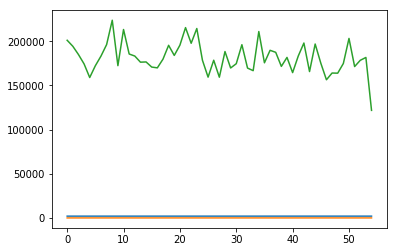

In [189]:
plt.plot(train.groupby(['YrSold', 'MoSold'], as_index=False)['SalePrice'].mean())

In [190]:
train[train['SalePrice']>700000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


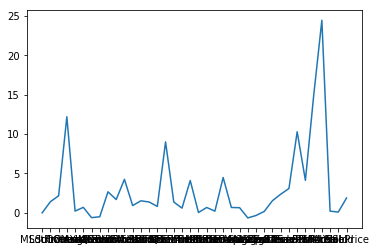

In [191]:
plt.plot(train_skew)

In [192]:
skewed_columns = train_skew.index[train_skew.abs()>1.5]

In [193]:
y_train = train['SalePrice'].values

In [194]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [195]:
test_id = test['Id'].values

In [196]:
del train['Id'], test['Id']

In [197]:
all_data = pd.concat([train, test], axis=0)

In [198]:
all_data.shape

(2919, 79)

In [199]:
all_data_skew = all_data[all_data.columns[train.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>1.5]

In [200]:
skewed_columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [201]:
stats.skew(np.log(y_train))

0.1212103673013655

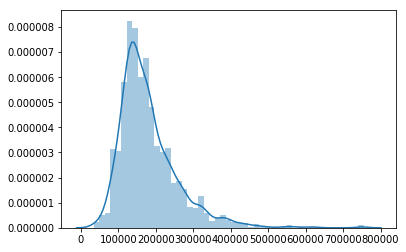

In [202]:
sns.distplot(y_train)

In [203]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
LotFrontage       486
GarageCond        159
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
BsmtFinSF2          1
BsmtFinSF1          1
Exterior2nd         1
BsmtUnfSF           1
TotalBsmtSF         1
Exterior1st         1
SaleType            1
Electrical          1
KitchenQual         1
GarageArea          1
GarageCars          1
OverallQual         0
OverallCond         0
LotArea             0
Street              0
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType  

In [204]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [205]:
all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

In [206]:
col_obj = all_data.columns[all_data.dtypes==object]
col_obj

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [207]:
all_data['Neighborhood+Exterior1st'] = all_data['Neighborhood'] + '+'+ all_data['Exterior1st']
all_data['MSZoning+CentralAir'] = all_data['MSZoning'] + '+'+ all_data['CentralAir']
all_data['OverallCond+BsmtExposure'] = all_data['OverallCond'] + '+'+ all_data['BsmtExposure']
all_data['Foundation+SaleCondition'] = all_data['Foundation'] + '+'+ all_data['SaleCondition']
all_data['Neighborhood+BsmtExposure'] = all_data['Neighborhood'] + '+'+ all_data['BsmtExposure']
all_data['Neighborhood+GarageFinish'] = all_data['Neighborhood'] + '+'+ all_data['GarageFinish']
all_data['Neighborhood+SaleCondition'] = all_data['Neighborhood'] + '+'+ all_data['SaleCondition']
all_data['Neighborhood+OverallCond'] = all_data['Neighborhood'] + '+'+ all_data['OverallCond']
all_data['KitchenQual+SaleCondition'] = all_data['KitchenQual'] + '+'+ all_data['SaleCondition']
all_data['Exterior1st+BsmtFinType1'] = all_data['Exterior1st'] + '+'+ all_data['BsmtFinType1']

In [208]:
all_data['MSZoning+OverallQual'] = all_data['MSZoning'] + '+'+ all_data['OverallQual']
all_data['FireplaceQu+GarageType'] = all_data['FireplaceQu'] + '+'+ all_data['GarageType']
all_data['OverallQual+PavedDrive'] = all_data['OverallQual'] + '+'+ all_data['PavedDrive']
all_data['OverallQual+CentralAir'] = all_data['OverallQual'] + '+'+ all_data['CentralAir']
all_data['RoofStyle+KitchenQual'] = all_data['RoofStyle'] + '+'+ all_data['KitchenQual']
all_data['KitchenQual+FireplaceQu'] = all_data['KitchenQual'] + '+'+ all_data['FireplaceQu']
all_data['BsmtExposure+KitchenQual'] = all_data['BsmtExposure'] + '+'+ all_data['KitchenQual']
all_data['BldgType+OverallQual'] = all_data['BldgType'] + '+'+ all_data['OverallQual']

In [209]:
all_data.shape

(2919, 97)

#all_data['OverallQual+Cond'] =(all_data['OverallQual']).astype(str) + (all_data['OverallCond']).astype(str)
#all_data['OverallQual*Cond'] =(all_data['OverallQual'] * all_data['OverallCond']).astype(str)


all_data['Neigh_Zone']  = all_data['Neighborhood'].astype(str) +'_'+ all_data['MSZoning'].astype(str)
all_data['SaleType_Condition']  = all_data['SaleType'].astype(str) +'_'+ all_data['SaleCondition'].astype(str)

In [210]:
col_obj = all_data.columns[all_data.dtypes==object]
col_obj

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition',
       'Neighborhood+Exterior1st', 'MSZoning+CentralAir',
       'OverallCond+BsmtExposure', 'Foundation+SaleCondition',
       'Neighborhood+BsmtExposure', 'Neighborhood+GarageFinish',
       'Neighborhood+SaleCondition', 'Neighborhood+OverallCond',
       'KitchenQual+SaleCondition', 'Exterior1st+BsmtFinType1',

In [211]:
col_num = all_data.columns[all_data.dtypes!=object]
col_num

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

all_data['TotalBsmt_0'] = (all_data['TotalBsmtSF']==0).astype(int)
all_data['1st-TotalBsmtSF'] = all_data['1stFlrSF'] - all_data['TotalBsmtSF']
all_data['2ndFlr_Flag'] = (all_data['2ndFlrSF']!=0).astype(int)
all_data['BsmtUnfRate'] = all_data['BsmtUnfSF']/all_data['1stFlrSF']
all_data['LowQualRate'] = all_data['LowQualFinSF']/all_data['GrLivArea']
all_data['1st/Lot']     = all_data['1stFlrSF']/all_data['LotArea']
all_data['1st+2ndSF']   = all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['2nd/1st']     = all_data['2ndFlrSF'] / all_data['1stFlrSF']
all_data['YearRemo-Gar'] = all_data['YearRemodAdd'] - all_data['GarageYrBlt']
all_data['1st+2nd+GarSF']= all_data['1st+2ndSF'] + all_data['GarageArea']
all_data['1st+2nd+Gar/Lot'] = all_data['1st+2nd+GarSF'] / all_data['LotArea']

In [212]:
for col in col_obj:
    all_data[col] = all_data[col].factorize()[0]

In [213]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
MasVnrArea,23,0.007879
BsmtFullBath,2,0.000685
BsmtHalfBath,2,0.000685
TotalBsmtSF,1,0.000343
BsmtFinSF1,1,0.000343
GarageArea,1,0.000343
GarageCars,1,0.000343
BsmtUnfSF,1,0.000343


In [214]:
all_data['LotFrontage'].mean()

69.30579531442663

In [215]:
all_data['GarageYrBlt'].fillna(0, inplace=True)

In [216]:
all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median()

201.0

In [217]:
all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

In [218]:
all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)

In [219]:
all_data.fillna(all_data.mean(), inplace=True)

In [220]:
all_data['YearBuilt/YrSold'] = all_data['YearBuilt']/(all_data['YrSold']+1)
#all_data['GrLivArea/BedroomAbvGr'] = all_data['GrLivArea']/(all_data['BedroomAbvGr']+1)
all_data['YearRemodAdd/YrSold'] = all_data['YearRemodAdd']/(all_data['YrSold']+1)
#all_data['TotalBsmtSF/KitchenAbvGr'] = all_data['TotalBsmtSF']/(all_data['KitchenAbvGr']+1)
#all_data['LotArea/LotFrontage'] = all_data['LotArea']/(all_data['LotFrontage']+1)
#all_data['LotArea/MiscVal'] = all_data['LotArea']/(all_data['MiscVal']+1)

#all_data['GrLivArea/KitchenAbvGr'] = all_data['GrLivArea']/(all_data['KitchenAbvGr']+1)
#all_data['GarageCars/KitchenAbvGr'] = all_data['GarageCars']/(all_data['KitchenAbvGr']+1)
#all_data['KitchenAbvGr/GarageCars'] = all_data['KitchenAbvGr']/(all_data['GarageCars']+1)
#all_data['GrLivArea/LowQualFinSF'] = all_data['GrLivArea']/(all_data['LowQualFinSF']+1)
#all_data['GarageArea/MiscVal'] = all_data['GarageArea']/(all_data['MiscVal']+1)

for i in range(len(col_num)):
    for j in range(len(col_num)):
        if i!=j:            
            all_data[str(col_num[i])+'/'+str(col_num[j])] = all_data[col_num[i]]/(all_data[col_num[j]]+1)

In [221]:
for i in range(len(col_num)):
    for j in range(i, len(col_num)):
        if i!=j:            
            all_data[str(col_num[i])+'+'+str(col_num[j])] = all_data[col_num[i]] + all_data[col_num[j]]

In [222]:
for i in range(len(col_num)):
    for j in range(i, len(col_num)):
        if i!=j:            
            all_data[str(col_num[i])+'-'+str(col_num[j])] = all_data[col_num[i]] - all_data[col_num[j]]

In [223]:
all_data.skew()

MSSubClass                     1.140549
MSZoning                       2.656140
LotFrontage                    1.675713
LotArea                       12.829025
Street                        15.508104
Alley                          4.140513
LotShape                       1.262181
LandContour                    3.407074
Utilities                    -10.372700
LotConfig                      1.382671
LandSlope                      4.977715
Neighborhood                   0.192788
Condition1                     3.737025
Condition2                    12.239955
BldgType                       2.165183
HouseStyle                     2.007841
OverallQual                    0.839296
OverallCond                    1.455416
YearBuilt                     -0.600114
YearRemodAdd                  -0.451252
RoofStyle                      3.647237
RoofMatl                       9.382127
Exterior1st                    1.206716
Exterior2nd                    1.054638
MasVnrType                     0.229984


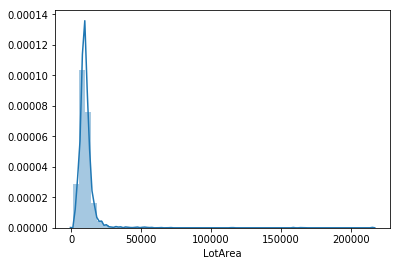

In [224]:
sns.distplot((all_data['LotArea']))

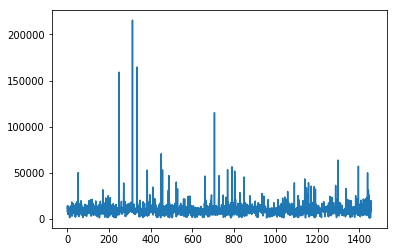

In [225]:
plt.plot((all_data['LotArea']))

In [226]:
all_data['LotArea'].mean()

10168.11408016444

In [227]:
#np.percentile(all_data['LotArea'], 95)

In [228]:
#all_data['LotArea'] = np.clip(all_data['LotArea'], a_min=all_data['LotArea'].min(), a_max=np.percentile(all_data['LotArea'], 95))

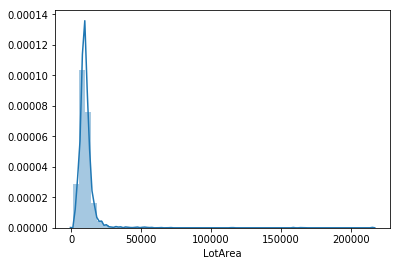

In [229]:
sns.distplot((all_data['LotArea']))

In [230]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Neighborhood+Exterior1st,MSZoning+CentralAir,OverallCond+BsmtExposure,Foundation+SaleCondition,Neighborhood+BsmtExposure,Neighborhood+GarageFinish,Neighborhood+SaleCondition,Neighborhood+OverallCond,KitchenQual+SaleCondition,Exterior1st+BsmtFinType1,MSZoning+OverallQual,FireplaceQu+GarageType,OverallQual+PavedDrive,OverallQual+CentralAir,RoofStyle+KitchenQual,KitchenQual+FireplaceQu,BsmtExposure+KitchenQual,BldgType+OverallQual,YearBuilt/YrSold,YearRemodAdd/YrSold,LotFrontage+LotArea,...,KitchenAbvGr-WoodDeckSF,KitchenAbvGr-OpenPorchSF,KitchenAbvGr-EnclosedPorch,KitchenAbvGr-3SsnPorch,KitchenAbvGr-ScreenPorch,KitchenAbvGr-PoolArea,KitchenAbvGr-MiscVal,KitchenAbvGr-MoSold,KitchenAbvGr-YrSold,TotRmsAbvGrd-Fireplaces,TotRmsAbvGrd-GarageYrBlt,TotRmsAbvGrd-GarageCars,TotRmsAbvGrd-GarageArea,TotRmsAbvGrd-WoodDeckSF,TotRmsAbvGrd-OpenPorchSF,TotRmsAbvGrd-EnclosedPorch,TotRmsAbvGrd-3SsnPorch,TotRmsAbvGrd-ScreenPorch,TotRmsAbvGrd-PoolArea,TotRmsAbvGrd-MiscVal,TotRmsAbvGrd-MoSold,TotRmsAbvGrd-YrSold,Fireplaces-GarageYrBlt,Fireplaces-GarageCars,Fireplaces-GarageArea,Fireplaces-WoodDeckSF,Fireplaces-OpenPorchSF,Fireplaces-EnclosedPorch,Fireplaces-3SsnPorch,Fireplaces-ScreenPorch,Fireplaces-PoolArea,Fireplaces-MiscVal,Fireplaces-MoSold,Fireplaces-YrSold,GarageYrBlt-GarageCars,GarageYrBlt-GarageArea,GarageYrBlt-WoodDeckSF,GarageYrBlt-OpenPorchSF,GarageYrBlt-EnclosedPorch,GarageYrBlt-3SsnPorch,GarageYrBlt-ScreenPorch,GarageYrBlt-PoolArea,GarageYrBlt-MiscVal,GarageYrBlt-MoSold,GarageYrBlt-YrSold,GarageCars-GarageArea,GarageCars-WoodDeckSF,GarageCars-OpenPorchSF,GarageCars-EnclosedPorch,GarageCars-3SsnPorch,GarageCars-ScreenPorch,GarageCars-PoolArea,GarageCars-MiscVal,GarageCars-MoSold,GarageCars-YrSold,GarageArea-WoodDeckSF,GarageArea-OpenPorchSF,GarageArea-EnclosedPorch,GarageArea-3SsnPorch,GarageArea-ScreenPorch,GarageArea-PoolArea,GarageArea-MiscVal,GarageArea-MoSold,GarageArea-YrSold,WoodDeckSF-OpenPorchSF,WoodDeckSF-EnclosedPorch,WoodDeckSF-3SsnPorch,WoodDeckSF-ScreenPorch,WoodDeckSF-PoolArea,WoodDeckSF-MiscVal,WoodDeckSF-MoSold,WoodDeckSF-YrSold,OpenPorchSF-EnclosedPorch,OpenPorchSF-3SsnPorch,OpenPorchSF-ScreenPorch,OpenPorchSF-PoolArea,OpenPorchSF-MiscVal,OpenPorchSF-MoSold,OpenPorchSF-YrSold,EnclosedPorch-3SsnPorch,EnclosedPorch-ScreenPorch,EnclosedPorch-PoolArea,EnclosedPorch-MiscVal,EnclosedPorch-MoSold,EnclosedPorch-YrSold,3SsnPorch-ScreenPorch,3SsnPorch-PoolArea,3SsnPorch-MiscVal,3SsnPorch-MoSold,3SsnPorch-YrSold,ScreenPorch-PoolArea,ScreenPorch-MiscVal,ScreenPorch-MoSold,ScreenPorch-YrSold,PoolArea-MiscVal,PoolArea-MoSold,PoolArea-YrSold,MiscVal-MoSold,MiscVal-YrSold,MoSold-YrSold
0,0,0,65.0,8450,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,2003,2003,0,0,0,0,0,196.0,0,0,0,0,0,0,0,706.0,0,0.0,150.0,856.0,0,0,0,0,856,854,0,1710,1.0,0.0,2,1,3,1,0,8,0,0,-1,0,2003.0,0,2.0,548.0,0,0,0,0,61,0,0,0,0,-1,-1,-1,0,2,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,0,0.997013,0.997013,8515.0,...,1,-60,1,1,1,1,1,-1,-2007,8,-1995.0,6.0,-540.0,8,-53,8,8,8,8,8,6,-2000,-2003.0,-2.0,-548.0,0,-61,0,0,0,0,0,-2,-2008,2001.0,1455.0,2003.0,1942.0,2003.0,2003.0,2003.0,2003.0,2003.0,2001.0,-5.0,-546.0,2.0,-59.0,2.0,2.0,2.0,2.0,2.0,0.0,-2006.0,548.0,

In [231]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [232]:
y_train_log = np.log(y_train)

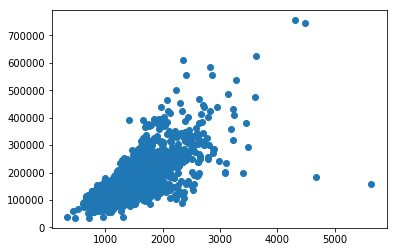

In [233]:
plt.scatter(x=train['GrLivArea'], y=y_train)

In [234]:
train[train['GrLivArea']>4000]['GrLivArea']

523     4676
691     4316
1182    4476
1298    5642
Name: GrLivArea, dtype: int64

In [235]:
train = pd.concat([train, pd.DataFrame({'SalePrice':y_train})], axis=1)

In [236]:
train.drop(train[train['GrLivArea']>4600].index, inplace=True)

In [237]:
train.shape

(1458, 1156)

In [238]:
def mean_encoding(train, test, cols):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    skf = skf.split(train, train['SalePrice'])
    for col in cols:
        train[col+'_mean_encoding'] = 0
        test[col+'_mean_encoding'] = test[col].map(train.groupby(col)['SalePrice'].mean())
    for tr_idx,val_idx in skf:
        X_tr, X_val = train.iloc[tr_idx, :], train.iloc[val_idx, :]
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col)['SalePrice'].mean())
            train[col+'_mean_encoding'].iloc[val_idx] = means
    prior = train['SalePrice'].mean()
    train.fillna(prior, inplace=True)
    test.fillna(prior, inplace=True)
    return train,test

In [239]:
#train, test = mean_encoding(train, test, col_obj)

In [240]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Neighborhood+Exterior1st,MSZoning+CentralAir,OverallCond+BsmtExposure,Foundation+SaleCondition,Neighborhood+BsmtExposure,Neighborhood+GarageFinish,Neighborhood+SaleCondition,Neighborhood+OverallCond,KitchenQual+SaleCondition,Exterior1st+BsmtFinType1,MSZoning+OverallQual,FireplaceQu+GarageType,OverallQual+PavedDrive,OverallQual+CentralAir,RoofStyle+KitchenQual,KitchenQual+FireplaceQu,BsmtExposure+KitchenQual,BldgType+OverallQual,YearBuilt/YrSold,YearRemodAdd/YrSold,LotFrontage+LotArea,...,KitchenAbvGr-OpenPorchSF,KitchenAbvGr-EnclosedPorch,KitchenAbvGr-3SsnPorch,KitchenAbvGr-ScreenPorch,KitchenAbvGr-PoolArea,KitchenAbvGr-MiscVal,KitchenAbvGr-MoSold,KitchenAbvGr-YrSold,TotRmsAbvGrd-Fireplaces,TotRmsAbvGrd-GarageYrBlt,TotRmsAbvGrd-GarageCars,TotRmsAbvGrd-GarageArea,TotRmsAbvGrd-WoodDeckSF,TotRmsAbvGrd-OpenPorchSF,TotRmsAbvGrd-EnclosedPorch,TotRmsAbvGrd-3SsnPorch,TotRmsAbvGrd-ScreenPorch,TotRmsAbvGrd-PoolArea,TotRmsAbvGrd-MiscVal,TotRmsAbvGrd-MoSold,TotRmsAbvGrd-YrSold,Fireplaces-GarageYrBlt,Fireplaces-GarageCars,Fireplaces-GarageArea,Fireplaces-WoodDeckSF,Fireplaces-OpenPorchSF,Fireplaces-EnclosedPorch,Fireplaces-3SsnPorch,Fireplaces-ScreenPorch,Fireplaces-PoolArea,Fireplaces-MiscVal,Fireplaces-MoSold,Fireplaces-YrSold,GarageYrBlt-GarageCars,GarageYrBlt-GarageArea,GarageYrBlt-WoodDeckSF,GarageYrBlt-OpenPorchSF,GarageYrBlt-EnclosedPorch,GarageYrBlt-3SsnPorch,GarageYrBlt-ScreenPorch,GarageYrBlt-PoolArea,GarageYrBlt-MiscVal,GarageYrBlt-MoSold,GarageYrBlt-YrSold,GarageCars-GarageArea,GarageCars-WoodDeckSF,GarageCars-OpenPorchSF,GarageCars-EnclosedPorch,GarageCars-3SsnPorch,GarageCars-ScreenPorch,GarageCars-PoolArea,GarageCars-MiscVal,GarageCars-MoSold,GarageCars-YrSold,GarageArea-WoodDeckSF,GarageArea-OpenPorchSF,GarageArea-EnclosedPorch,GarageArea-3SsnPorch,GarageArea-ScreenPorch,GarageArea-PoolArea,GarageArea-MiscVal,GarageArea-MoSold,GarageArea-YrSold,WoodDeckSF-OpenPorchSF,WoodDeckSF-EnclosedPorch,WoodDeckSF-3SsnPorch,WoodDeckSF-ScreenPorch,WoodDeckSF-PoolArea,WoodDeckSF-MiscVal,WoodDeckSF-MoSold,WoodDeckSF-YrSold,OpenPorchSF-EnclosedPorch,OpenPorchSF-3SsnPorch,OpenPorchSF-ScreenPorch,OpenPorchSF-PoolArea,OpenPorchSF-MiscVal,OpenPorchSF-MoSold,OpenPorchSF-YrSold,EnclosedPorch-3SsnPorch,EnclosedPorch-ScreenPorch,EnclosedPorch-PoolArea,EnclosedPorch-MiscVal,EnclosedPorch-MoSold,EnclosedPorch-YrSold,3SsnPorch-ScreenPorch,3SsnPorch-PoolArea,3SsnPorch-MiscVal,3SsnPorch-MoSold,3SsnPorch-YrSold,ScreenPorch-PoolArea,ScreenPorch-MiscVal,ScreenPorch-MoSold,ScreenPorch-YrSold,PoolArea-MiscVal,PoolArea-MoSold,PoolArea-YrSold,MiscVal-MoSold,MiscVal-YrSold,MoSold-YrSold,SalePrice
0,0,0,65.0,8450,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,2003,2003,0,0,0,0,0,196.0,0,0,0,0,0,0,0,706.0,0,0.0,150.0,856.0,0,0,0,0,856,854,0,1710,1.0,0.0,2,1,3,1,0,8,0,0,-1,0,2003.0,0,2.0,548.0,0,0,0,0,61,0,0,0,0,-1,-1,-1,0,2,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,0,0.997013,0.997013,8515.0,...,-60,1,1,1,1,1,-1,-2007,8,-1995.0,6.0,-540.0,8,-53,8,8,8,8,8,6,-2000,-2003.0,-2.0,-548.0,0,-61,0,0,0,0,0,-2,-2008,2001.0,1455.0,2003.0,1942.0,2003.0,2003.0,2003.0,2003.0,2003.0,2001.0,-5.0,-546.0,2.0,-59.0,2.0,2.0,2.0,2.0,2.0,0.0,-2006.0,548.0,487.0,548.0,548.

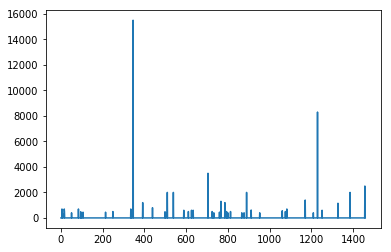

In [241]:
plt.plot(train['MiscVal'])

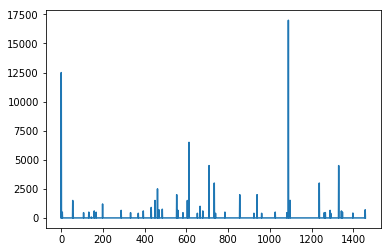

In [242]:
plt.plot(test['MiscVal'])

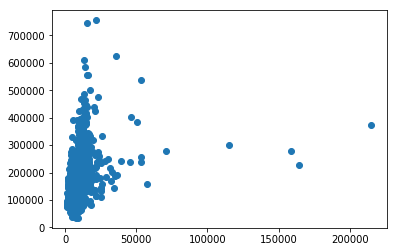

In [243]:
plt.scatter(x=train['LotArea'], y=train['SalePrice'])

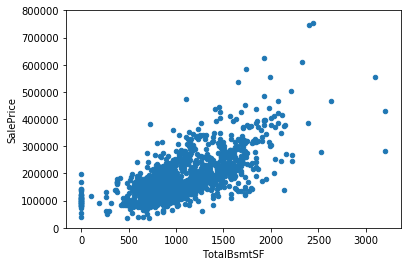

In [244]:
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

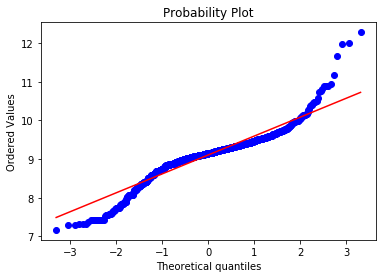

In [245]:
res = stats.probplot(np.log(train['LotArea']), plot=plt)

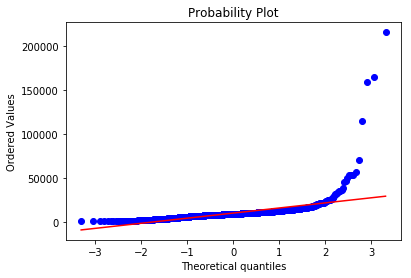

In [246]:
res = stats.probplot(train['LotArea'], plot=plt)

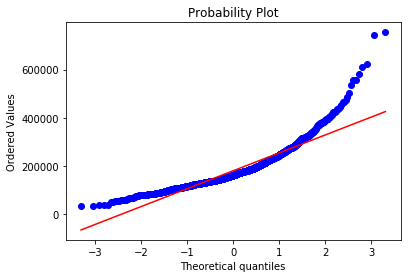

In [247]:
res = stats.probplot(train['SalePrice'], plot=plt)

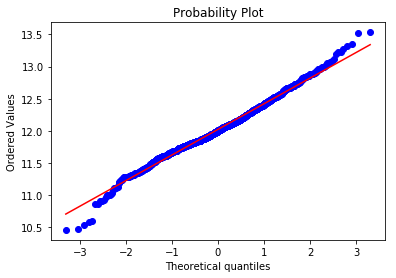

In [248]:
res = stats.probplot(np.log(train['SalePrice']), plot=plt)

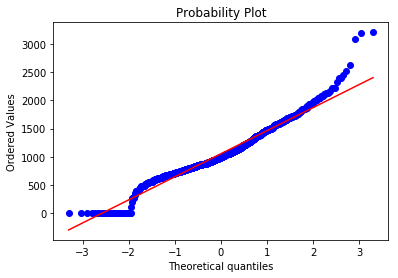

In [249]:
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

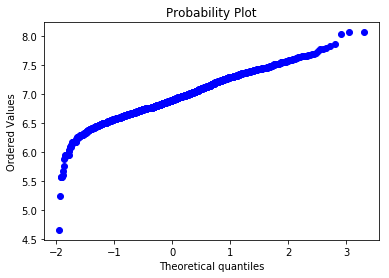

In [250]:
res = stats.probplot(np.log(train['TotalBsmtSF']), plot=plt)

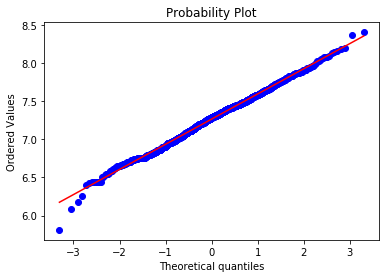

In [251]:
res = stats.probplot(np.log(train['GrLivArea']), plot=plt)

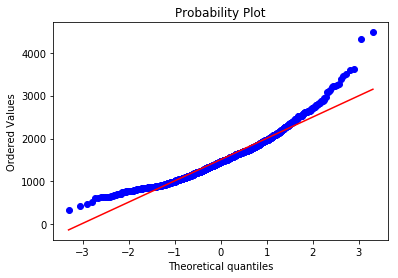

In [252]:
res = stats.probplot(train['GrLivArea'], plot=plt)

In [253]:
sf_cols = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
          'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [254]:
cols = ['TotalBsmtSF', 'LotArea']

for df in [train, test]:
    #df['GrLivArea_log'] = np.log(df['GrLivArea'])        
    #df['YrRem-Bui'] = df['YearRemodAdd'] - df['YearBuilt']
    for col in sf_cols:
        df[col+'_sqrt'] = np.sqrt(df[col]) 
        df[col+'_log'] = np.zeros(df.shape[0])
        df[col+'_log'].loc[df[df[col]>0].index] = np.log(df[col])

In [255]:
y_train = train['SalePrice'].values
del train['SalePrice']

In [256]:
all_data = pd.concat([train, test], axis=0)
#ob_col = all_data.columns[all_data.dtypes==object]

In [257]:
#all_data.fillna('NA', inplace=True)
#all_data[col_obj] = all_data[col_obj].astype(str)
#all_data = pd.get_dummies(all_data)

In [258]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [259]:
train.shape

(1458, 1155)

In [260]:
y_train_log = np.log(y_train)

In [261]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=False, random_state=123)

In [262]:
ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.linear_model import LinearRegression, Lasso

reg_lasso = []
val_rmse_lasso = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.001).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

coef = pd.Series(model_lasso.coef_, index = train.columns)

coef

dropf = coef.loc[coef==0].index
print(dropf)

0.13637108701487807
Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'Exterior1st',
       'MasVnrArea', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2',
       ...
       'ScreenPorch-PoolArea', 'ScreenPorch-MiscVal', 'ScreenPorch-MoSold',
       'ScreenPorch-YrSold', 'PoolArea-MiscVal', 'PoolArea-MoSold',
       'PoolArea-YrSold', 'MiscVal-MoSold', 'MiscVal-YrSold', 'MoSold-YrSold'],
      dtype='object', length=1054)


In [263]:
0.12075221409291992

0.12075221409291992

In [264]:
#train = train.drop(dropf, axis=1)

In [265]:
coef.sort_values(ascending=False)

MSZoning+CentralAir           0.056246
BsmtFinSF1+GrLivArea          0.047914
TotalBsmtSF+GrLivArea         0.042446
YearRemodAdd/YrSold           0.038349
YearBuilt+YearRemodAdd        0.030245
LotFrontage+GrLivArea         0.027613
BsmtFinSF2+GrLivArea          0.023779
FullBath-KitchenAbvGr         0.021425
GarageArea+WoodDeckSF         0.020382
YearBuilt+ScreenPorch         0.018556
FireplaceQu                   0.018173
OverallCond+BsmtExposure      0.016644
HalfBath-KitchenAbvGr         0.015261
MasVnrArea+TotalBsmtSF        0.013986
LotFrontage+YearBuilt         0.013428
RoofStyle+KitchenQual         0.013352
OverallQual+CentralAir        0.012729
HouseStyle                    0.012295
FullBath-BedroomAbvGr         0.011563
GrLivArea+GarageYrBlt         0.011503
Neighborhood+Exterior1st      0.011403
BsmtQual                      0.011051
YearBuilt+GrLivArea           0.010667
TotalBsmtSF+2ndFlrSF          0.009808
BldgType                      0.009448
LandContour              

In [266]:
lgb_params = {
               'feature_fraction': 0.75,
               'max_depth': 3,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

In [267]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.35849
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.334386
[3]	valid_0's rmse: 0.311309
[4]	valid_0's rmse: 0.290629
[5]	valid_0's rmse: 0.272551
[6]	valid_0's rmse: 0.255206
[7]	valid_0's rmse: 0.241523
[8]	valid_0's rmse: 0.228218
[9]	valid_0's rmse: 0.217559
[10]	valid_0's rmse: 0.207403
[11]	valid_0's rmse: 0.197884
[12]	valid_0's rmse: 0.191423
[13]	valid_0's rmse: 0.183856
[14]	valid_0's rmse: 0.177384
[15]	valid_0's rmse: 0.171155
[16]	valid_0's rmse: 0.166267
[17]	valid_0's rmse: 0.161497
[18]	valid_0's rmse: 0.158414
[19]	valid_0's rmse: 0.155033
[20]	valid_0's rmse: 0.152302
[21]	valid_0's rmse: 0.149845
[22]	valid_0's rmse: 0.148443
[23]	valid_0's rmse: 0.146131
[24]	valid_0's rmse: 0.143942
[25]	valid_0's rmse: 0.14209
[26]	valid_0's rmse: 0.140037
[27]	valid_0's rmse: 0.138949
[28]	valid_0's rmse: 0.13748
[29]	valid_0's rmse: 0.136533
[30]	valid_0's rmse: 0.135463
[31]	valid_0's rmse: 0.134571
[32]	valid_0's rmse

[296]	valid_0's rmse: 0.119875
[297]	valid_0's rmse: 0.119895
[298]	valid_0's rmse: 0.119859
[299]	valid_0's rmse: 0.119868
[300]	valid_0's rmse: 0.119756
[301]	valid_0's rmse: 0.11972
[302]	valid_0's rmse: 0.119799
[303]	valid_0's rmse: 0.119811
[304]	valid_0's rmse: 0.119773
[305]	valid_0's rmse: 0.119789
[306]	valid_0's rmse: 0.119842
[307]	valid_0's rmse: 0.119835
[308]	valid_0's rmse: 0.119901
[309]	valid_0's rmse: 0.119827
[310]	valid_0's rmse: 0.119817
[311]	valid_0's rmse: 0.119757
[312]	valid_0's rmse: 0.119715
[313]	valid_0's rmse: 0.11971
[314]	valid_0's rmse: 0.119622
[315]	valid_0's rmse: 0.119644
[316]	valid_0's rmse: 0.119653
[317]	valid_0's rmse: 0.119629
[318]	valid_0's rmse: 0.119677
[319]	valid_0's rmse: 0.119707
[320]	valid_0's rmse: 0.119685
[321]	valid_0's rmse: 0.119651
[322]	valid_0's rmse: 0.119635
[323]	valid_0's rmse: 0.11965
[324]	valid_0's rmse: 0.119674
[325]	valid_0's rmse: 0.119709
[326]	valid_0's rmse: 0.119733
[327]	valid_0's rmse: 0.119737
[328]	valid

[166]	valid_0's rmse: 0.133889
[167]	valid_0's rmse: 0.134003
[168]	valid_0's rmse: 0.13402
[169]	valid_0's rmse: 0.134043
[170]	valid_0's rmse: 0.134096
[171]	valid_0's rmse: 0.134109
[172]	valid_0's rmse: 0.134072
[173]	valid_0's rmse: 0.13406
[174]	valid_0's rmse: 0.133975
[175]	valid_0's rmse: 0.134154
[176]	valid_0's rmse: 0.134247
[177]	valid_0's rmse: 0.134249
[178]	valid_0's rmse: 0.134248
[179]	valid_0's rmse: 0.134238
[180]	valid_0's rmse: 0.134298
[181]	valid_0's rmse: 0.134262
[182]	valid_0's rmse: 0.134233
[183]	valid_0's rmse: 0.134193
[184]	valid_0's rmse: 0.134165
[185]	valid_0's rmse: 0.134229
[186]	valid_0's rmse: 0.13417
[187]	valid_0's rmse: 0.134129
[188]	valid_0's rmse: 0.134109
[189]	valid_0's rmse: 0.134122
[190]	valid_0's rmse: 0.134177
[191]	valid_0's rmse: 0.13418
[192]	valid_0's rmse: 0.134198
[193]	valid_0's rmse: 0.134255
[194]	valid_0's rmse: 0.134279
[195]	valid_0's rmse: 0.134273
[196]	valid_0's rmse: 0.134286
[197]	valid_0's rmse: 0.134307
[198]	valid_

[172]	valid_0's rmse: 0.132147
[173]	valid_0's rmse: 0.132113
[174]	valid_0's rmse: 0.131866
[175]	valid_0's rmse: 0.13192
[176]	valid_0's rmse: 0.13192
[177]	valid_0's rmse: 0.131884
[178]	valid_0's rmse: 0.131903
[179]	valid_0's rmse: 0.131951
[180]	valid_0's rmse: 0.132023
[181]	valid_0's rmse: 0.132049
[182]	valid_0's rmse: 0.132059
[183]	valid_0's rmse: 0.13203
[184]	valid_0's rmse: 0.132056
[185]	valid_0's rmse: 0.132102
[186]	valid_0's rmse: 0.132056
[187]	valid_0's rmse: 0.131937
[188]	valid_0's rmse: 0.131899
[189]	valid_0's rmse: 0.131942
[190]	valid_0's rmse: 0.131885
[191]	valid_0's rmse: 0.131905
[192]	valid_0's rmse: 0.131938
[193]	valid_0's rmse: 0.132012
[194]	valid_0's rmse: 0.13209
[195]	valid_0's rmse: 0.132147
[196]	valid_0's rmse: 0.132146
[197]	valid_0's rmse: 0.132124
[198]	valid_0's rmse: 0.132159
[199]	valid_0's rmse: 0.132118
[200]	valid_0's rmse: 0.132211
[201]	valid_0's rmse: 0.132267
[202]	valid_0's rmse: 0.13232
[203]	valid_0's rmse: 0.132319
[204]	valid_0

[441]	valid_0's rmse: 0.131945
[442]	valid_0's rmse: 0.131863
[443]	valid_0's rmse: 0.13188
[444]	valid_0's rmse: 0.131866
[445]	valid_0's rmse: 0.131855
[446]	valid_0's rmse: 0.131874
[447]	valid_0's rmse: 0.131884
[448]	valid_0's rmse: 0.131873
[449]	valid_0's rmse: 0.131844
[450]	valid_0's rmse: 0.131871
Early stopping, best iteration is:
[350]	valid_0's rmse: 0.131628
[1]	valid_0's rmse: 0.356815
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.332745
[3]	valid_0's rmse: 0.311724
[4]	valid_0's rmse: 0.293426
[5]	valid_0's rmse: 0.276408
[6]	valid_0's rmse: 0.261535
[7]	valid_0's rmse: 0.247381
[8]	valid_0's rmse: 0.23485
[9]	valid_0's rmse: 0.223336
[10]	valid_0's rmse: 0.214013
[11]	valid_0's rmse: 0.204519
[12]	valid_0's rmse: 0.196772
[13]	valid_0's rmse: 0.189372
[14]	valid_0's rmse: 0.183104
[15]	valid_0's rmse: 0.177664
[16]	valid_0's rmse: 0.173409
[17]	valid_0's rmse: 0.168365
[18]	valid_0's rmse: 0.164496
[19]	valid_0's rmse: 0.161956
[2

[297]	valid_0's rmse: 0.124123
[298]	valid_0's rmse: 0.124175
[299]	valid_0's rmse: 0.124153
[300]	valid_0's rmse: 0.124001
[301]	valid_0's rmse: 0.12414
[302]	valid_0's rmse: 0.124096
[303]	valid_0's rmse: 0.124065
[304]	valid_0's rmse: 0.124021
[305]	valid_0's rmse: 0.123952
[306]	valid_0's rmse: 0.123855
[307]	valid_0's rmse: 0.123816
[308]	valid_0's rmse: 0.123808
[309]	valid_0's rmse: 0.123865
[310]	valid_0's rmse: 0.123841
[311]	valid_0's rmse: 0.123996
[312]	valid_0's rmse: 0.124101
[313]	valid_0's rmse: 0.124181
[314]	valid_0's rmse: 0.124153
[315]	valid_0's rmse: 0.124132
[316]	valid_0's rmse: 0.124112
[317]	valid_0's rmse: 0.124077
[318]	valid_0's rmse: 0.124017
[319]	valid_0's rmse: 0.123924
[320]	valid_0's rmse: 0.123872
[321]	valid_0's rmse: 0.123826
[322]	valid_0's rmse: 0.123795
[323]	valid_0's rmse: 0.123774
[324]	valid_0's rmse: 0.123752
[325]	valid_0's rmse: 0.123791
[326]	valid_0's rmse: 0.123714
Early stopping, best iteration is:
[226]	valid_0's rmse: 0.123273
[1]	v

[258]	valid_0's rmse: 0.124451
[259]	valid_0's rmse: 0.124441
[260]	valid_0's rmse: 0.124445
[261]	valid_0's rmse: 0.124373
[262]	valid_0's rmse: 0.124357
[263]	valid_0's rmse: 0.124355
[264]	valid_0's rmse: 0.124333
[265]	valid_0's rmse: 0.124382
[266]	valid_0's rmse: 0.12444
[267]	valid_0's rmse: 0.124412
[268]	valid_0's rmse: 0.124421
[269]	valid_0's rmse: 0.124416
[270]	valid_0's rmse: 0.124394
[271]	valid_0's rmse: 0.124301
[272]	valid_0's rmse: 0.12446
[273]	valid_0's rmse: 0.124486
[274]	valid_0's rmse: 0.124442
[275]	valid_0's rmse: 0.124469
[276]	valid_0's rmse: 0.124429
[277]	valid_0's rmse: 0.124391
[278]	valid_0's rmse: 0.12441
[279]	valid_0's rmse: 0.124557
[280]	valid_0's rmse: 0.124582
[281]	valid_0's rmse: 0.124618
[282]	valid_0's rmse: 0.124544
[283]	valid_0's rmse: 0.124692
[284]	valid_0's rmse: 0.124702
[285]	valid_0's rmse: 0.124632
[286]	valid_0's rmse: 0.124635
[287]	valid_0's rmse: 0.12469
[288]	valid_0's rmse: 0.124786
[289]	valid_0's rmse: 0.124748
[290]	valid_

In [268]:
np.sum(val_rmse)/n_folds

0.12638980426810525

In [269]:
0.12312769839085329

0.12312769839085329

In [270]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [271]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

,Importance
TotalBsmtSF+GrLivArea,22.4
OverallCond+BsmtExposure,21.2
Neighborhood+Exterior1st,20.8
OverallCond,20.0
Foundation+SaleCondition,17.0
BsmtFinSF1+GrLivArea,16.0
Functional,13.8
Neighborhood+OverallCond,12.4
MSZoning+OverallQual,11.8
Neighborhood,11.6


In [272]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance(importance_type='gain')

In [273]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

,Importance
TotalBsmtSF+GrLivArea,328.721660
GrLivArea+GarageArea,95.665177
Fireplaces+GarageCars,48.680078
BsmtFinSF1+GrLivArea,46.400654
FullBath-KitchenAbvGr,40.804755
OverallQual+CentralAir,36.599259
KitchenAbvGr-GarageCars,25.660841
YearBuilt+YearRemodAdd,20.096875
TotalBsmtSF+2ndFlrSF,19.817792
LotFrontage+GarageYrBlt,11.308279


In [92]:
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = 4,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(train_ss, y_train_log)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

0.13918941729963422
{'gamma': 0.0001, 'epsilon': 0.0001, 'C': 10}


In [93]:
preds = svr.predict(test_ss)

In [ ]:
drop_f2 = importance[importance['Importance']==0].index

In [ ]:
for df in [train, test]:
    df = df.drop(drop_f2, axis=1)

In [ ]:
train = train.drop(drop_f2, axis=1)

In [ ]:
test = test.drop(dropf, axis=1)
test = test.drop(drop_f2, axis=1)

In [ ]:
reg_lasso = []
val_rmse_lasso = []

ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.005).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

In [ ]:
preds = None

for model in reg:
    if preds is None:
        preds = model.predict(test) / n_folds
    else:
        preds += model.predict(test) / n_folds

In [ ]:
np.exp(preds)

In [ ]:
sns.distplot(np.exp(preds))

In [ ]:
solution = pd.DataFrame({"id":test_id, "SalePrice":np.exp(preds)})
solution.to_csv("submission_34.csv", index = False)